## Практическое задание к уроку 7
Исполнитель: Васильев Антон

### Задание
Берем отызывы за лето (из архива с материалами или предыдущего занятия)
1. Учим conv сеть для классификации
2. Рассмотреть 2-а варианта сеточек
2.1 Инициализировать tf.keras.layers.Embedding предобученными векторами взять к примеру с https://rusvectores.org/ru/
2.2 Инициализировать слой tf.keras.layers.Embedding по умолчанию (ну то есть вам ничего не делать с весами)

Сравнить две архитектуры с предобученными весами и когда tf.keras.layers.Embedding обучается сразу со всей сеточкой, что получилось лучше

In [1]:
import pandas as pd

df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_val = pd.read_csv("data/val.csv")

In [2]:
df_train.head()

,id,text,class
0,0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1


In [3]:
df_test.head()

,id,text
0,204150,Тектоника и рельеф-самое ужасное в мире мучение(
1,204151,"Ходили запускать шар желаний, но у нас не полу..."
2,204152,"Хочу лето только ради того, что бы направить н..."
3,204153,RT @RonyLiss: @colf_ne блин((\nа я шипперила Ф...
4,204154,"RT @anna_romt: @ZADROT_PO_IGRAM блин,каждое во..."


In [4]:
df_val.head()

,id,text,class
0,181467,RT @TukvaSociopat: Максимальный репост! ))) #є...,1
1,181468,чтоб у меня з.п. ежегодно индексировали на инд...,0
2,181469,@chilyandlime нехуя мне не хорошо !!! :((((,0
3,181470,"@inafish нее , когда ногами ахахах когда?ахаха...",0
4,181471,"Хочу сделать как лучше, а получаю как всегда. :(",0


<BarContainer object of 170 artists>

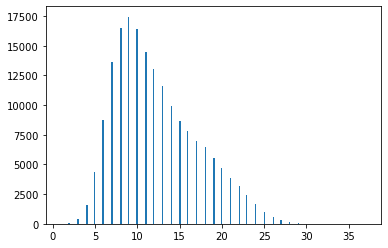

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

_, _, hist = plt.hist(df_train.text.apply(lambda text: len(text.split())), bins='auto')
hist

In [6]:
max_words = 1000
max_len = 30
num_classes = 1

# Training
epochs = 20
batch_size = 512
print_batch_n = 100

### Предобработка

In [18]:
# !pip install stop_words
# !pip install pymorphy2

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32912 sha256=75c043c88ad02633f123a2d6a34bc00699c13d0e56eb1c0e2ff5bce90fd5bce4
  Stored in directory: c:\users\avasilev\appdata\local\pip\cache\wheels\eb\03\0d\3bd31c983789aeb0b4d5e2ca48590288d9db1586cf5f225062
Successfully built stop-words


In [7]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

In [8]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

df_train['text'] = df_train['text'].apply(preprocess_text)
df_val['text'] = df_val['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

In [9]:
train_corpus = " ".join(df_train["text"])
train_corpus = train_corpus.lower()

In [10]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

tokens = word_tokenize(train_corpus)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AVasilev\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Отфильтруем данные

и соберём в корпус N наиболее частых токенов

In [11]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [12]:
from nltk.probability import FreqDist
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [108]:
tokens_filtered_top.remove('rt')
tokens_filtered_top.remove('d')
tokens_filtered_top.remove('3')
tokens_filtered_top.remove('2')
tokens_filtered_top.remove('5')
tokens_filtered_top.remove('4')
tokens_filtered_top.remove('оо')
tokens_filtered_top[:10]

['хотеть',
 'знать',
 'ян',
 'мочь',
 'новый',
 'любить',
 'завтра',
 'мой',
 'хороший',
 'делать']

In [91]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [92]:
import numpy as np

def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [93]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["text"]], dtype=np.int32)
x_test = np.asarray([text_to_sequence(text, max_len) for text in df_test["text"]], dtype=np.int32)
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["text"]], dtype=np.int32)

In [94]:
x_train.shape

(181467, 30)

In [95]:
max_len

30

In [96]:
x_train[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
       206, 441, 163,   7])

# Keras model

In [62]:
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPool1D, MaxPool1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import TensorBoard 
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.utils import get_file, to_categorical
from tensorflow.keras.initializers import Constant

Загружаю предобученную модель tayga_upos_skipgram_300_2_2019

In [21]:
data_path = get_file(
    "185.zip",
    "http://vectors.nlpl.eu/repository/20/185.zip",
    extract=True,
)

639279104/639268566 [==============================] - 181s 0us/step


In [23]:
import os
import pathlib

In [24]:
data_dir = pathlib.Path(data_path).parent
data_dir

WindowsPath('C:/Users/AVasilev/.keras/datasets')

In [30]:
with open(data_dir / "README") as f:
    print(f.read())

This archive is part of the NLPL Word Vectors Repository (http://vectors.nlpl.eu/repository/), version 2.0, published on Friday, December 27, 2019.
Please see the file 'meta.json' in this archive and the overall repository metadata file http://vectors.nlpl.eu/repository/20.json for additional information.
The life-time identifier for this model is:
http://vectors.nlpl.eu/repository/20/185.zip


In [31]:
with open(data_dir / "meta.json") as f:
    print(f.read())

{
    "algorithm": {
        "command": null,
        "id": 0,
        "name": "Gensim Continuous Skipgram",
        "tool": "Gensim",
        "url": "https://github.com/RaRe-Technologies/gensim",
        "version": "3.6"
    },
    "contents": [
        {
            "filename": "model.txt",
            "format": "text"
        },
        {
            "filename": "model.bin",
            "format": "data"
        },
        {
            "filename": "meta.json",
            "format": "json"
        }
    ],
    "corpus": [
        {
            "NER": true,
            "case preserved": false,
            "description": "Taiga corpus",
            "id": 93,
            "language": "rus",
            "lemmatized": true,
            "public": true,
            "stop words removal": "functional PoS",
            "tagger": "UDPipe 1.2",
            "tagset": "UPoS",
            "tokens": 4867000000,
            "url": "https://tatianashavrina.github.io/taiga_site/"
        }
    ],
    "c

In [41]:
%%time
path_to_model_file = os.path.join(data_dir, 'model.txt')

embeddings_index = {}
with open(path_to_model_file, encoding='utf-8') as f:
    for line in f:
        word_, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        try:
            word, _ = word_.split('_')
        except ValueError:
            embeddings_index[word_] = coefs
        else:
            embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 195436 word vectors.
Wall time: 28.7 s


In [97]:
word_index = dict(zip(vocabulary, range(len(vocabulary))))

In [98]:
num_tokens = len(vocabulary) + 2
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in vocabulary.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print(f"Converted {hits} words ({misses} misses)")

Converted 901 words (91 misses)


Активирую слой Embedding весами из скачанной модели

In [99]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=Constant(embedding_matrix),
    trainable=False,
)

Обучу 2 одинаковый сети: с слоем Embedding, обучающимся с обучением сетки, и с слоем Embedding, у которого веса уже были предобучены.

In [51]:
num_classes = 2
y_train = to_categorical(df_train["class"], num_classes)
y_val = to_categorical(df_val["class"], num_classes)

In [100]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(Conv1D(128, 3, activation="relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(20, activation="relu"))
model.add(Dense(num_classes, activation="softmax"))

In [101]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [102]:
tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_loss', patience=5)  


history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_val, y_val),
                    callbacks=[tensorboard, early_stopping])

Epoch 1/20
355/355 [==============================] - 8s 23ms/step - loss: 0.6095 - accuracy: 0.6568 - val_loss: 0.5987 - val_accuracy: 0.6672
Epoch 2/20
355/355 [==============================] - 8s 22ms/step - loss: 0.5818 - accuracy: 0.6818 - val_loss: 0.5951 - val_accuracy: 0.6713
Epoch 3/20
355/355 [==============================] - 8s 23ms/step - loss: 0.5681 - accuracy: 0.6926 - val_loss: 0.5952 - val_accuracy: 0.6716
Epoch 4/20
355/355 [==============================] - 8s 22ms/step - loss: 0.5503 - accuracy: 0.7060 - val_loss: 0.5974 - val_accuracy: 0.6686
Epoch 5/20
355/355 [==============================] - 8s 21ms/step - loss: 0.5270 - accuracy: 0.7214 - val_loss: 0.6088 - val_accuracy: 0.6718
Epoch 6/20
355/355 [==============================] - 8s 24ms/step - loss: 0.4971 - accuracy: 0.7418 - val_loss: 0.6305 - val_accuracy: 0.6704
Epoch 7/20
355/355 [==============================] - 8s 23ms/step - loss: 0.4648 - accuracy: 0.7591 - val_loss: 0.6704 - val_accuracy: 0.6576

In [103]:
pred = model.predict(x_test, batch_size=batch_size, verbose=1)

45/45 [==============================] - 0s 6ms/step


In [104]:
# model with pre-trained weights
model_ptw = Sequential()
model_ptw.add(embedding_layer)
model_ptw.add(Conv1D(128, 3, activation="relu"))
model_ptw.add(GlobalMaxPool1D())
model_ptw.add(Dense(20, activation="relu"))
model_ptw.add(Dense(num_classes, activation="softmax"))

In [105]:
model_ptw.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [106]:
history_ptw = model_ptw.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_val, y_val),
                    callbacks=[tensorboard, early_stopping])

Epoch 1/20
355/355 [==============================] - 12s 33ms/step - loss: 0.6229 - accuracy: 0.6416 - val_loss: 0.6121 - val_accuracy: 0.6556
Epoch 2/20
355/355 [==============================] - 12s 33ms/step - loss: 0.5862 - accuracy: 0.6767 - val_loss: 0.6080 - val_accuracy: 0.6604
Epoch 3/20
355/355 [==============================] - 12s 33ms/step - loss: 0.5662 - accuracy: 0.6926 - val_loss: 0.6100 - val_accuracy: 0.6606
Epoch 4/20
355/355 [==============================] - 12s 34ms/step - loss: 0.5439 - accuracy: 0.7076 - val_loss: 0.6174 - val_accuracy: 0.6577
Epoch 5/20
355/355 [==============================] - 12s 33ms/step - loss: 0.5250 - accuracy: 0.7201 - val_loss: 0.6403 - val_accuracy: 0.6526
Epoch 6/20
355/355 [==============================] - 11s 32ms/step - loss: 0.5016 - accuracy: 0.7355 - val_loss: 0.6442 - val_accuracy: 0.6571
Epoch 7/20
355/355 [==============================] - 12s 33ms/step - loss: 0.4819 - accuracy: 0.7466 - val_loss: 0.6735 - val_accuracy:

In [107]:
pred_ptw = model_ptw.predict(x_test, batch_size=batch_size, verbose=1)

45/45 [==============================] - 1s 10ms/step


#### Выводы:
1. Модели с предобученными весами и без показали одинаковый результат.
2. Для обучения модели с предобученми весами необходимо на 43% больше времени, чем на модель, у которой веса обучаются вместе с сеткой.